In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import ast

In [2]:
# Load the summaries + embeddings + cluster IDs
df = pd.read_csv("merged_clustered_summaries.csv")
df['Embedding'] = df['Embedding'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))
df.head()
# Force pandas to treat the entire row as a single string, then split it manually
# centroids_df = pd.read_csv("cluster_centroids_k30.csv")  # Assumes first row is header
# centroids = centroids_df['Centroid_Vector'].apply(lambda x: np.array(list(map(float, x.split(','))))).to_list()

,Summary,Embedding,New_Cluster_Label
0,we started our lecture with a recap of previou...,"[-0.5317, -0.5215, 0.3384, 0.06107, 0.3943, 0....",107
1,"in this session, we explored various feature e...","[-0.567, -0.4575, 0.0715, 0.11566, -0.2205, 0....",9
2,population and sample were further discussed u...,"[-0.556, -0.4207, 0.622, 0.1076, 0.0618, -0.31...",102
3,we first looked at all the summaries and obser...,"[-0.7803, -0.7134, 0.6514, -0.02931, -0.07306,...",5
4,midsem metrics for evaluation and also discuss...,"[-0.3196, -0.33, 0.2173, 0.4011, -0.1698, -0.0...",100


C:\Users\pradh\AppData\Local\Temp\ipykernel_5644\2387463803.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=new_cluster_counts.index, y=new_cluster_counts.values, palette="viridis")


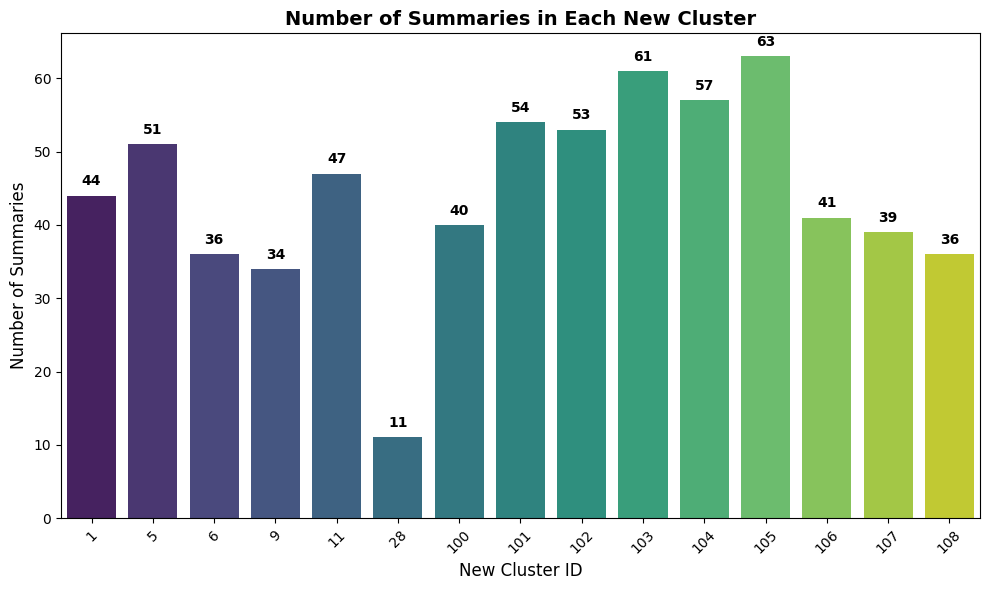

In [3]:
# Count summaries per new cluster
new_cluster_counts = df['New_Cluster_Label'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=new_cluster_counts.index, y=new_cluster_counts.values, palette="viridis")

# Annotate count on each bar
for i, count in enumerate(new_cluster_counts.values):
    ax.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Number of Summaries in Each New Cluster", fontsize=14, weight='bold')
plt.xlabel("New Cluster ID", fontsize=12)
plt.ylabel("Number of Summaries", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [4]:
# Compute centroids for each cluster
centroid_dict = {}
for cluster_id in sorted(df['New_Cluster_Label'].unique()):
    cluster_embeddings = np.vstack(df[df['New_Cluster_Label'] == cluster_id]['Embedding'].values)
    centroid = np.mean(cluster_embeddings, axis=0)
    centroid_dict[cluster_id] = centroid

# Print most representative summary (first 100 words)
print("Representative Summary for Each Cluster:\n")
for cluster_id, centroid in centroid_dict.items():
    cluster_data = df[df['New_Cluster_Label'] == cluster_id].copy()
    embeddings = np.vstack(cluster_data['Embedding'].tolist())
    
    similarities = cosine_similarity([centroid], embeddings).flatten()
    closest_idx = similarities.argmax()
    summary = cluster_data.iloc[closest_idx]['Summary']
    
    short_summary = ' '.join(summary.strip().split()[:40])
    
    print(f"👉Cluster {cluster_id} — Representative Summary:")
    print(f"{short_summary}\n{'-' * 100}")


Representative Summary for Each Cluster:

👉Cluster 1 — Representative Summary:
we began with an analysis of pivot tables in excel, which can be helpful for summarizing large datasets by arranging and aggregating information. we learned how to create pivot tables, re-arrange fields, and calculate important metrics like sums, averages, counts,
----------------------------------------------------------------------------------------------------
👉Cluster 5 — Representative Summary:
to improve the quality of results we can improve the sample by either increasing quality of sample or size of sample. we can improve the method by using multiple methods and select best one. also we can fine tune and
----------------------------------------------------------------------------------------------------
👉Cluster 6 — Representative Summary:
variance inflation factor (vif) purpose: detects and addresses multicollinearity among independent features. process: involves an iterative approach to select inde

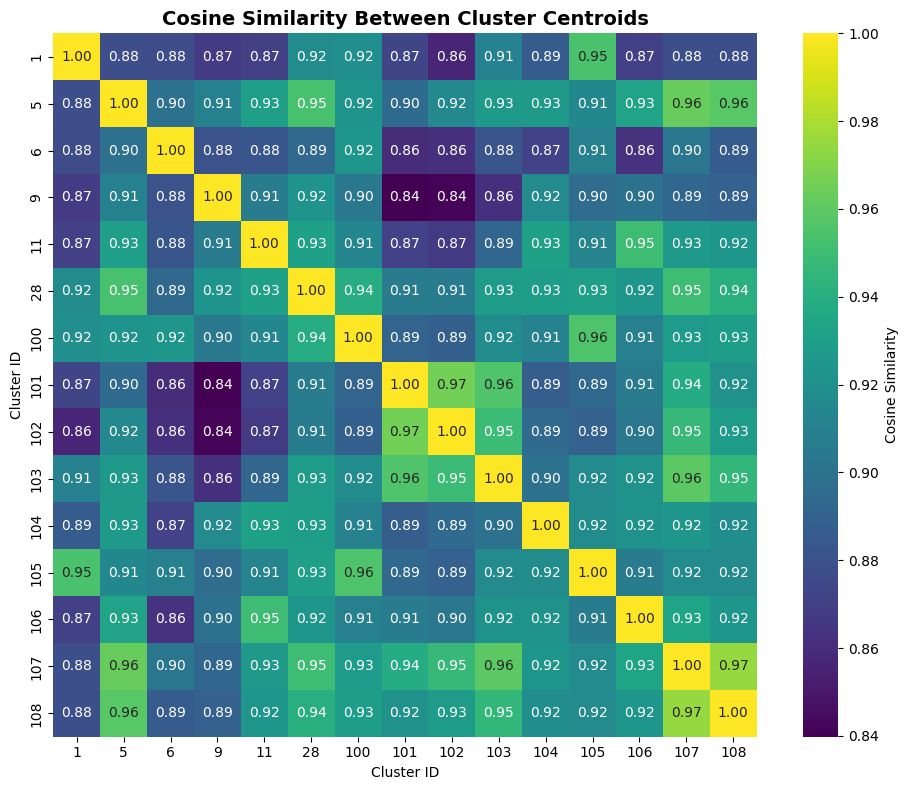

In [5]:
# Convert centroid dictionary to array and labels
centroid_ids = sorted(centroid_dict.keys())
centroid_vectors = np.vstack([centroid_dict[cid] for cid in centroid_ids])

# Compute similarity matrix
centroid_sim_matrix = cosine_similarity(centroid_vectors)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(centroid_sim_matrix, xticklabels=centroid_ids, yticklabels=centroid_ids,
            cmap='viridis', annot=True, fmt=".2f", square=True, cbar_kws={'label': 'Cosine Similarity'})

plt.title("Cosine Similarity Between Cluster Centroids", fontsize=14, weight='bold')
plt.xlabel("Cluster ID")
plt.ylabel("Cluster ID")
plt.tight_layout()
plt.show()


In [6]:
def print_top_cluster_summaries(cluster_id, top_n=10):
    cluster_data = df[df['New_Cluster_Label'] == cluster_id].copy()
    if len(cluster_data) == 0:
        print(f"No summaries found for Cluster {cluster_id}")
        return
    
    centroid = centroid_dict[cluster_id].reshape(1, -1)
    embeddings = np.vstack(cluster_data['Embedding'].values)
    similarities = cosine_similarity(embeddings, centroid).flatten()
    
    cluster_data['Similarity'] = similarities
    top_summaries = cluster_data.sort_values(by='Similarity', ascending=False).head(top_n)

    print(f"\n--- Top {top_n} Summaries for Cluster {cluster_id} ---\n")
    for i, row in enumerate(top_summaries.itertuples(), 1):
        preview = ' '.join(row.Summary.split()[:50])
        print(f"👉 Summary {i}: {preview}\n")

print_top_cluster_summaries(cluster_id=108, top_n=10)


--- Top 10 Summaries for Cluster 108 ---

👉 Summary 1: for multiple linear regression, the closed form solution for b exists but it might be impractical to calculate these as matrix inversions might not exist and etc. if we have a sample of data, we should not use the entire data for creating the ml model. we need to split

👉 Summary 2: for a mlr, in theory, closed form solution exists but in practicality, the closed form solution is not taken into consideration due to two reasons 1. finding inverse of large matrices is difficult and 2. there can be multi-collinearity. from a population we take sample, but in order to train

👉 Summary 3: we recapped in the starting about the closed form solution in multiple linear regression which is impractical as we have to deal with matrix inversion and also one more issue is presence of multi collinearity. also during feature selection if p value is greater than 0.05 we remove that feature

👉 Summary 4: class 8, explained how multicollinearity can

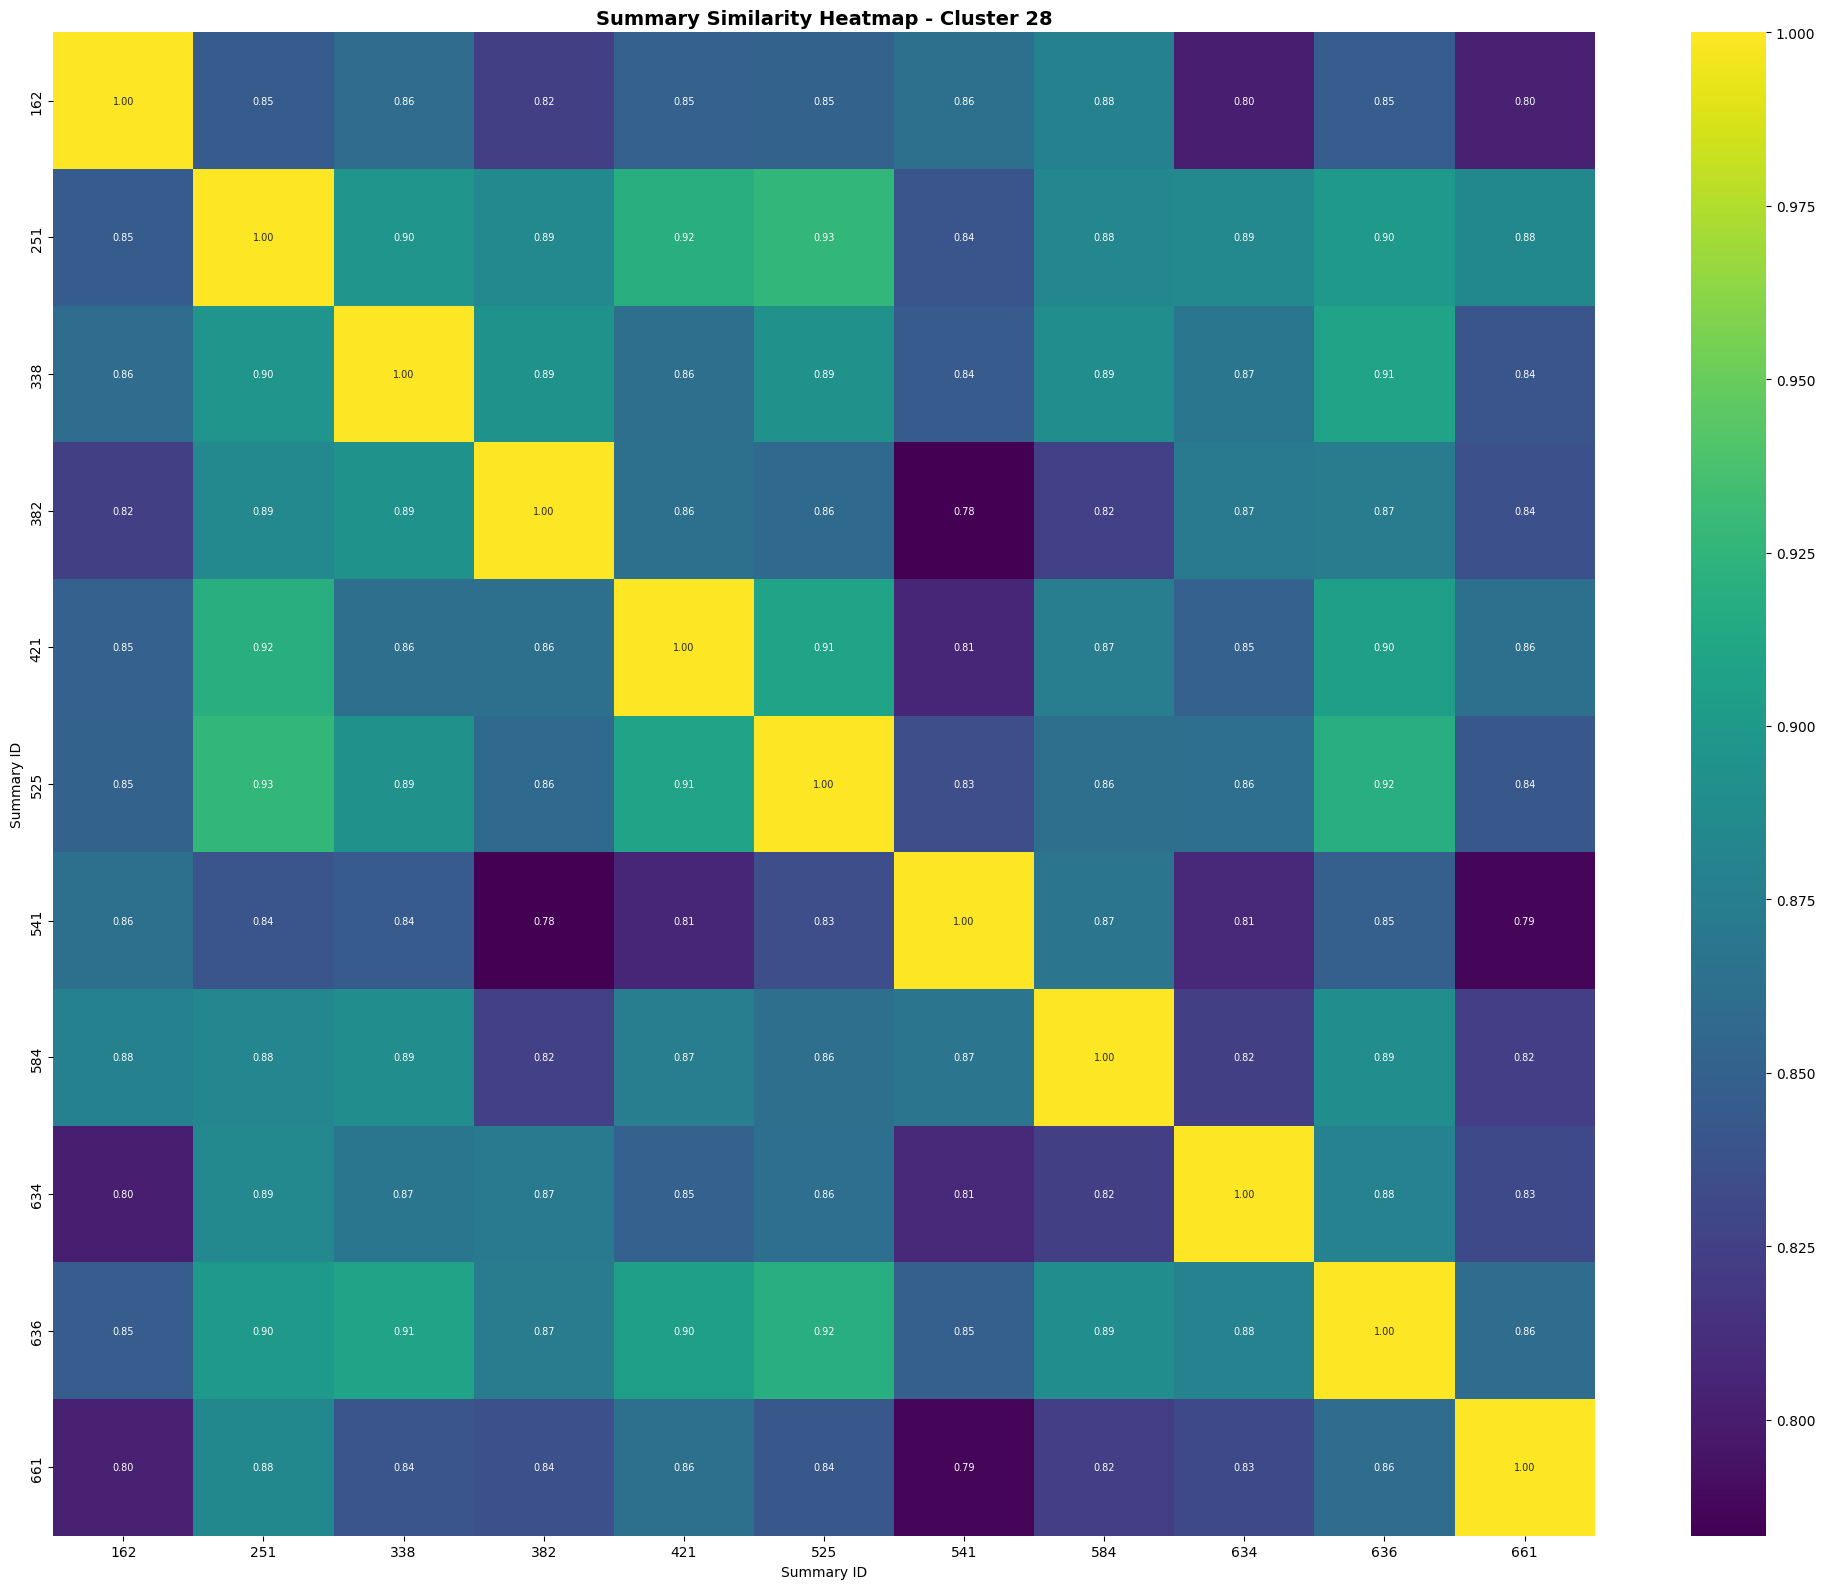


👉 Representative Summary for Cluster 28 (ID: 251)
🔗 Cosine similarity to centroid: 0.9601
sir started the classes by discussing about confid


In [7]:
def plot_cluster_summary_similarity(cluster_id):
    cluster_data = df[df['New_Cluster_Label'] == cluster_id].copy()

    if len(cluster_data) < 2:
        print(f"Cluster {cluster_id} has fewer than 2 summaries.")
        return

    embeddings = np.vstack(cluster_data['Embedding'].tolist())
    similarity_matrix = cosine_similarity(embeddings)

    centroid = np.mean(embeddings, axis=0).reshape(1, -1)
    similarities = cosine_similarity(embeddings, centroid).flatten()
    cluster_data['Similarity'] = similarities

    rep_row = cluster_data.iloc[similarities.argmax()]
    rep_summary = rep_row['Summary']
    rep_summary_id = rep_row.name
    rep_similarity = rep_row['Similarity']

    summary_ids = cluster_data.index.tolist()

    plt.figure(figsize=(20, 16))
    sns.heatmap(similarity_matrix, 
                xticklabels=summary_ids, 
                yticklabels=summary_ids, 
                cmap='viridis', 
                annot=True, 
                fmt=".2f", 
                annot_kws={"size": 7})
    plt.title(f"Summary Similarity Heatmap - Cluster {cluster_id}", fontsize=14, weight='bold')
    plt.xlabel("Summary ID")
    plt.ylabel("Summary ID")
    plt.tight_layout()
    plt.show()

    print(f"\n👉 Representative Summary for Cluster {cluster_id} (ID: {rep_summary_id})")
    print(f"🔗 Cosine similarity to centroid: {rep_similarity:.4f}")
    print(rep_summary[:50])  # print first 50 characters


plot_cluster_summary_similarity(28)

In [8]:
def print_summary_by_index(index):
    try:
        summary = df.loc[index, 'Summary']
        print(f"\n📄 Summary ID: {index}\n")
        print(summary)
    except KeyError:
        print(f"❌ Summary with index {index} not found.")
        
print_summary_by_index(0)  # replace 123 with your summary index



📄 Summary ID: 0

we started our lecture with a recap of previous lecture particularly about the difference between statistically similar values and statistically significant values. we then started a new topic called as multiple linear regression. as the name suggests, it is a linear regression but dependent upon multiple features. we looked how things like sales depend on multiple factors like age, earning, family size etc. the things on which our y is dependent are known as features. our goal is to represent y as a linear combination of x1, x2, x3, ..., xn. suppose y = b0 + b1x1 + b2x2 + ...... our objective is to find the values of b0, b1, b2 which we do by a method called as gradient descent which is a numerical method very similar to newton raphson method, but used for n dimensions. prof then showed an illustration on excel where the y was dependent on 5 features. we performed mlr and had a look at the p-values of the calculated coefficients. every coefficient had a p-value great

In [9]:
# Step 1: Mapping of summary index to new cluster ID
update_map = {
    88: 104, 153: 105, 304: 108, 498: 107, 646: 11,
    162: 101, 251: 107, 338: 107, 382: 107, 421: 107,
    525: 107, 541: 107, 584: 100, 634: 107, 636: 107, 661: 108
}

# Step 2: Apply updates
for idx, new_label in update_map.items():
    if idx in df.index:
        df.loc[idx, 'New_Cluster_Label'] = new_label
    else:
        print(f"❗ Index {idx} not found in DataFrame.")

# Step 3: Save required columns to CSV
df[['Summary', 'Embedding', 'New_Cluster_Label']].to_csv("Final_merged_clusters.csv", index=True)
